#Financial data and random matrix theory in iPython

In [14]:
# preamble: packages we need
from pandas import DataFrame, Series
import pandas as pd
import pandas.io.data as web
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import cPickle as pickle
import csv
%matplotlib inline

In [15]:
#
# some helpful functions
# 
def compute_timeseries_corr(r):
    """compute a covariance from a multi-dimensional time series
    r is interpreted as N x M where N is number of observations and M is number of dimensions of the series"""
    x = np.dot(r.T, r)
    d = np.sqrt(np.diag(x))
    return x / np.outer(d, d)
def print_eigenvalue_stats(eigs):
    print "eigenvalue count = %d min eigenvalue = %.2g max eigenvalue = %.2g" % (len(eigs), min(eigs), max(eigs))
def print_corr_stats(corr):
    n = corr.shape[0]
    # set the correlations to nan
    d = (corr + np.diag(np.ones(n) * float('nan'))).flatten()
    d = d[np.isfinite(d)]
    print "minimum correlation = %.2g maximum correlation = %.2g" % (min(d), max(d))

Load our principal dataset from Yahoo! finance. They seem to have the best freely available financial data source (for stocks, anyway). We focus on US stocks in the S&P 500; it wouldn't be hard to do this analysis for any other dataset available on Yahoo!; the hard thing is choosing a scope. The S&P 500 is nice because it is an easy way to choose a tractable scope, and the data are likely to be high quality.

In this case, the data is identified by a "ticker" a string of letters that identify an equity security.
* IBM is the ticker for IBM
* YHOO for Yahoo!
* AAPL for Apple
* MSFT for Microsoft
* GOOG for Google
* FB for Facebook
* KO for Coke
* PEP for Pepsi
* etc

You want to be a bit careful about this: the mapping is not one-to-one: companies can change their tickers, tickers get recycled (C is Citigroup but was Chrysler; Blackberry is BBRY but was RIM).

In [16]:
# so as not to kill the internet connection, I've saved the data from yahoo to disk
load_from_disk = True
filename = 'yahoo_data.p'
if load_from_disk:
    with open(filename, 'rb') as p:
        price_data = pickle.load(p)
else:
    # here is how you would get the data from the web
    # I got this file from here: http://data.okfn.org/data/core/s-and-p-500-companies
    with open('constituents.csv', 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        all_tickers = [ row['Symbol'] for row in reader ]
    # end date is implicitly today
    start_date = '2001-01-01'
    price_data = {}
    bad_tickers = []
    for ticker in all_tickers:
        try:
            price_data[ticker] = web.get_data_yahoo(ticker, start_date)
        except IOError as ioe:
            bad_tickers.append(ticker)
    print len(bad_tickers), "bad tickers =", bad_tickers
    pickle.dump(price_data, open(filename, 'wb'))

## Stylized facts from a single equity
Let's quickly see some attributes of the series for a single equity instrument. Here we pick IBM ("no one ever got fired for choosing IBM"). The DataFrame for a single ticker consists of six columns:
* Open/High/Low/Close: these are respectively the price at which the stock starts trading, ends normal trading, the lowest price, and the highest price for the day all in USD per share.
* The volume is the volume for the day (in shares). To get volume in dollars multiply a price by the volume.
* The most important column is "adjusted close". The closing price is usually considered to be the best (most robust) price for analysis. The adjustment is that prices can actually be easily compared day-to-day because the effects of splits and dividends have been removed. Units are USD per share.

Be careful about comparing different instruments; in most cases you need to either be comparing something in USD (i.e. $(\text{price})\times(\text{shares})$) or dimensionless.

               Open     High      Low    Close    Volume  Adj Close
Date                                                               
2001-01-02  84.5000  87.5000  84.1250  84.8125   8007200  68.083102
2001-01-03  83.7500  95.0000  83.7500  94.6250  12769900  75.960071
2001-01-04  94.7500  99.7500  92.6875  93.1875  15420500  74.806120
2001-01-05  93.9375  94.6875  91.0000  94.0000   8043200  75.458354
2001-01-08  93.5000  93.9375  91.5625  93.5625   6064800  75.107151


(<matplotlib.legend.Legend at 0x7f4226a17b50>,
 <matplotlib.text.Text at 0x7f4226bac450>)

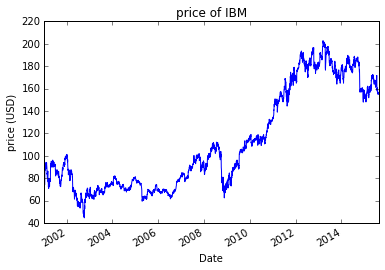

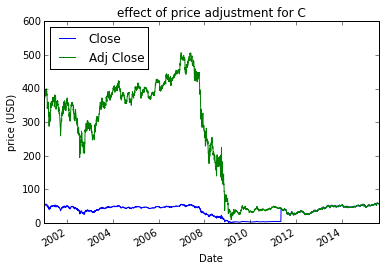

In [17]:
# plot IBM
base_ticker = 'IBM'
base_data = price_data[base_ticker]
print base_data.head()
base_data['Adj Close'].plot()
plt.title('price of ' + base_ticker), plt.ylabel('price (USD)')
# show a ticker with a split (like AAPL)
plt.figure()
split_ticker = 'C'
for k in ['Close', 'Adj Close']:
    price_data[split_ticker][k].plot(label=k)
plt.legend(loc='upper left'), plt.ylabel('price (USD)'), plt.title('effect of price adjustment for ' + split_ticker)

What can we say about this time series? One thing we can do is investigate the time-series of returns. The returns are defined as the change in price from one day to the next:
$$r_i=\log\frac{p_t}{p_{t-1}}.$$
We use the geometric return (i.e. we take a logarithm) instead of $r_i=p_t/p_{t-1}-1$ because of compounding: we want a return of $+x$ followed by a return of $-x$ to net out to zero return: $(1+x)(1-x)\ne 1$ but $e^{x}e^{-x}=1$. Let's plot the returns for IBM:

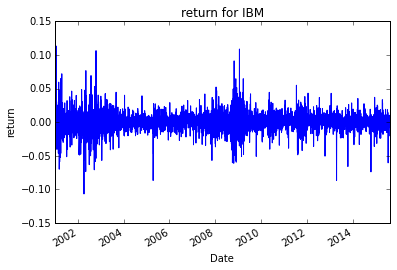

In [18]:
base_ret = base_data['Adj Close'].pct_change().apply(np.log1p)
plt.ylabel('return'), plt.title('return for ' + base_ticker)
base_ret.plot()

We don't learn too much from this. It doesn't look correlated? We can test this by looking at the autocorrelation.

Maybe the average ampltiude of the returns is correlated? We believe this to be true: the amplitudes are large in the financial crisis in 2008 and in the tech crash around 2001. 

((-0.2, 0.2), (0, 500), <matplotlib.text.Text at 0x7f4227cb9a50>)

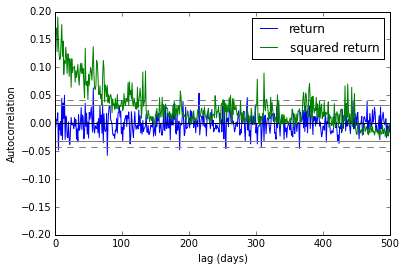

In [19]:
pd.tools.plotting.autocorrelation_plot(base_ret.dropna(), label='return')
pd.tools.plotting.autocorrelation_plot(base_ret.apply(np.square).dropna(), label='squared return')
plt.ylim((-0.2, 0.2)), plt.xlim((0, 500)), plt.xlabel('lag (days)')

Another thing to do is to plot the normalized density of returns.
We can observe:
- IBM returns have positive skew (third moment): roughly speaking, if you normalize to mean zero, then the positive tail is fatter
- They have large kurtosis/fourth moment. This means that they have fat tails; definitely inconsistent with being normal
- The plot shows the density of returns: definitely has fat tails
IBM is a relatively typical example here, except that the skewness overall for stocks is usually negative (if a big surprise comes, it usually means the stock has gone way down, not up).

maximum 7.28378543164 minimum -6.87172236877 skew 0.166100779961 kurtosis 6.86672878623


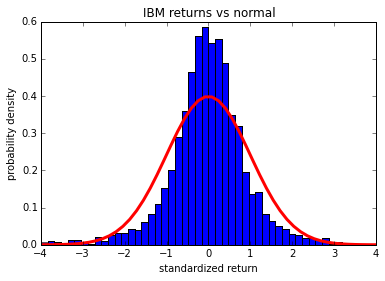

In [20]:
l = 4.0
mean, std = base_ret.mean(), base_ret.std()
norm_ret = (base_ret - mean) / std
print "maximum", np.amax(norm_ret), "minimum", np.amin(norm_ret), 'skew', scipy.stats.skew(norm_ret.dropna()), 'kurtosis', scipy.stats.kurtosis(norm_ret.dropna())
plt.hist(norm_ret, 50, range=(-l, l), normed=True)
xs = np.linspace(-l, l)
ys = np.exp(-xs * xs / 2.0) / np.sqrt(2.0 * np.pi)
plt.plot(xs, ys, color='r', linewidth=3.0)
plt.xlim((-l, l)), plt.xlabel('standardized return'), plt.ylabel('probability density'), plt.title(base_ticker + ' returns vs normal')
None

There is a lot of discussion in the literature about this. Some questions people are asking:
* what is the underlying distribution of stock returns?
* can you make the returns normal (or almost normal) by postulating some kind of hidden variable for the underlying returns $r_i=\sigma_i\epsilon_i$, where $\sigma_i$ is some measure of the volatility of the world and the $\epsilon_i$ are more-or-less normally distributed random variables?
* are they described by a "long memory process" ?

##Structure of equity correlations

Now instead of looking a single equity, or treating them as independent units, we change our point of view.
Forget about the individual instruments and look at the strucutre of the multivariate time series of all instruments.
Treat each individual series as a source of independent random variables: we are interested in looking at their correlations. We have downloaded about 14.5 years of data. Each day has 252 days. That's ~ 3500 days of data for ~ 500 instruments. A characteristic feature is that the ratio of data to variables is relatively small. Let's call it Q:

$$Q=\frac{(\text{# samples})}{(\text{# dimensions})}.$$

Here the dimensions is the number of instruments. 15 years is a long time. In this time:
* Had a major financial crisis
* Big tech companies had their IPOs (Google, Facebook)
* General Motors went bankrupt (and had an IPO)
* Apple went from being a terrible company to the biggest in the world
So if anything we are using way too much data here.

We are using returns at a frequency of one day. You could get better estimates by using higher frequency data, but it doesn't help as much as you'd think:
* Using shorter term returns means they have higher kurtosis
* Weird finance effects start to be important; tick sizes, bid-ask bounce (the tendency of the price to oscillate between two values), timestamp issues (if we trade at discrete times, what is the "price" at the other times?) 

In other words, *everything is non-stationary*.

In [21]:
price = DataFrame({tic: data['Adj Close'] for tic, data in price_data.iteritems()})
raw_returns = price.pct_change().apply(np.log1p)
n_days = max(raw_returns.count())
# the query for ACT returns the same data as for AGN? are they the same thing? remove it
del raw_returns['ACT']
print "DataFrame shape =", raw_returns.shape, "number of days =", n_days

DataFrame shape = (3713, 490) number of days = 3678


In [22]:
## here we filter out tickers that have missing returns
## there are probably some holes in the data, some do not have data for the whole sample period
## if we don't filter out here, we have to fill in missing values in the correlation matrix
## and we will still get negative eigenvalues that we have to figure out something to do with it
#returns = raw_returns.copy()
#missing_tickers = []
#for k in returns:
#    if returns[k].count() != n_days:
#        missing_tickers.append(k)
#        del returns[k]
#print len(missing_tickers), "tickers with missing data = ", missing_tickers

#corr = raw_returns.loc[['KO', 'PEP', 'IBM'],:].corr()
#print corr
print raw_returns.loc[:,['KO','PEP','IBM','BAC','C']].corr()

           KO       PEP       IBM       BAC         C
KO   1.000000  0.581703  0.353606  0.292873  0.306178
PEP  0.581703  1.000000  0.317273  0.291958  0.301083
IBM  0.353606  0.317273  1.000000  0.383641  0.417770
BAC  0.292873  0.291958  0.383641  1.000000  0.792062
C    0.306178  0.301083  0.417770  0.792062  1.000000


##Why do we care about this?

Theoretical model for the return of instrument $i$ at time $t$:
$$r_{it}=\sum_{a=1}^F f_{ia}\eta_{at} + \sigma_i\epsilon_{it}.$$
Here if there are $N$ instruments and $F$ factors, so $f_{ia}$ is an $N\times F$ matrix called the "factor loadings". Usually we want $F\ll N$ so that this is a kind of dimensional reduction. Here $\sigma_i$ is called the "specific" or "idiosyncratic" volatility and we imagine that $\epsilon_{it}$ are independent identically distributed random variables. The $\eta_{at}$ are random variables that can have a non-trivial covariance matrix. 
How do we get these factors?
1. Fundamental factor model: do a lot of work building a matrix of $f_{ia}$ from fundamental variables (what industry is the company in? how is it exposed to exchange rate fluctuations? does it have a lot of debt?) and then compute the $\eta_{at}$ using regression.
2. Macroeconomic factor model: use returns on important economic variables (interest rates, oil prices, currency exchange rates) as the $$\eta_{at}$$ and estimate the $f_{ia}$ using regression.
3. Statistical factor model: figure out everything from the $r_{it}$ themselves using some kind of fancy statisical method.

The most obvious method for statistical factor models is using "principal component analysis" which is a fancy way to say use the eigenvalues of the correlation matrix of $r_{it}$ (or the singular value decomposition of $r_{it}$ itself) to decompose the correlations. That's the path we'll take here. Note that the $\eta_{at}$ are by construction uncorrelated in these models. This means the model is very simple, but the orthogonal directions are unlikely to represent anything in the real world as factors you can actually interpret are likely to be correlated. 

##Why do we care about factors so much?

* Factors, if they correspond to something meaningful (as in the fundamental and macro factor models) allow us to interpret what is happening in the market (e.g. airlines are down because oil prices went up).
* They simplify calculating risk (the model is more compact and faster to calculate)
* A good factor model is more robust than a using realized covariances. In particular, we care as much about having a good estimate of the inverse of the covariance matrix as we do about using the covariances themselves.

If we have random errors in the correlations, then for a random portfolio the errors will cancel and be unbiased. But if we try to choose a portfolio to minimize risk, then the errors will *amplify*. (The pithy way to say this is that "optimizers are error maximizers.")

Q = 7.6
eigenvalue count = 490 min eigenvalue = 0.07 max eigenvalue = 1.7e+02
minimum correlation = -0.053 maximum correlation = 0.89


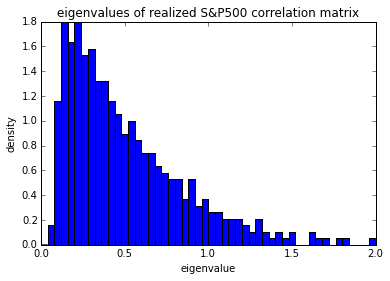

In [24]:
rmax = 2.0
s = raw_returns.shape
q = float(s[0])/ s[1]
# we have some non-overlapping instruments -- we are filling the missing returns in with zeros.
# This affects the result, and is the easiest but maybe not the best approach.
# If we did it differently, say substituting 0.0 or the average correlation for the missing
# correlations directly in the correlation matrix, we would get "better" results but the
# matrix would not be positive definite.
corr = raw_returns.fillna(0.0).corr()
raw_e = np.linalg.eigvals(corr)
plt.hist(raw_e, 50, range=(0.0, rmax), normed=True)
plt.xlabel('eigenvalue'), plt.ylabel('density'), plt.title('eigenvalues of realized S&P500 correlation matrix')
print "Q = %.2g" % q
print_eigenvalue_stats(raw_e)
print_corr_stats(corr.values)

If this were a good approximation of the identity matrix, the eigenvalues would be clustered around one. It doesn't look like they are. But what would it look like if the matrix were completely uncorrelated? One thing we can do is look at the same calculation if every timeseries were independently shuffled.

eigenvalue count = 490 min eigenvalue = 0.41 max eigenvalue = 1.9
minimum correlation = -0.13 maximum correlation = 0.16


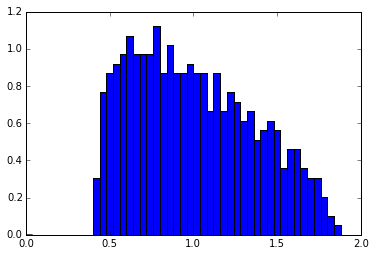

In [26]:
# there's a way to do this with pandas DataFrame, but I'm not smart enough to figure it out
shuff_r = raw_returns.fillna(0.0).values.copy()
# shuffle each column independently
# the returns for each stock are shuffled, this will destroy the correlations
for i in range(0, shuff_r.shape[1]):
    np.random.shuffle(shuff_r[:,i])
# compute correlations the old fashioned way
shuff_c = compute_timeseries_corr(shuff_r)
shuff_e = np.linalg.eigvals(shuff_c)
plt.hist(shuff_e, 50, range=(0.0, rmax), normed=True)
print_eigenvalue_stats(shuff_e)
print_corr_stats(shuff_c)

This looks completely different. This is a stable shape; we'll get a similar looking result if we shuffle again. This shape will be explained in a moment; first, let's look at the top and bottom eigenvectors.

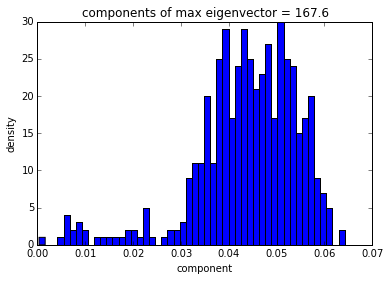

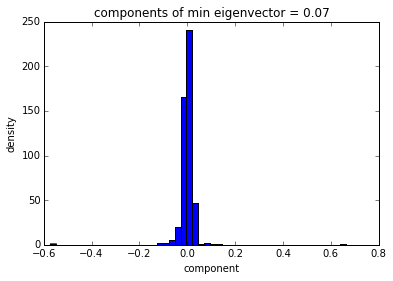

In [61]:
w, v = np.linalg.eig(corr)
mne, mxe = v[:,np.argmin(w)], v[:,np.argmax(w)]
plt.figure()
plt.ylabel('density'), plt.xlabel('component'), plt.title('components of max eigenvector = %.4g' % max(w))
plt.hist(mxe, 50)
plt.figure()
plt.ylabel('density'), plt.xlabel('component'), plt.title('components of min eigenvector = %.2g' % min(w))
plt.hist(mne, 50)
None

The factor with the most variance is a kind of a "market factor" because it has a positive loading on almost everything. And the eigenvalue is an order of magnitude higher than the next highest.
The factor with the least variance is approximately the difference of two very correlated instruments. They turn out to be Avalon Bay (AVB) and Equity Residential (EQR), two real estate investment trust companies that build and operate inexpensive residential rental buildings.

In [62]:
sort_w = w.sort()
print "min eig =", w[0], "2nd low =", w[1], "2nd high =", w[-2], "max eig =", w[-1]
mnticker, mxticker = corr.iloc[np.argmin(mne)].name, corr.iloc[np.argmax(mne)].name
print "largest components of lowest-variance eigenvalue = (%s, %.2g), (%s, %.2g); correlation = %.3g" % (mnticker, min(mne), mxticker, max(mne), corr[mnticker][mxticker])

min eig = 0.0704059627476 2nd low = 0.0726938764428 2nd high = 15.9467814146 max eig = 167.644929496
largest components of lowest-variance eigenvalue = (AVB, -0.57), (EQR, 0.66); correlation = 0.888


##Random matrix theory
What does a random covariance matrix look like?

eigenvalue count = 490 min eigenvalue = 0.41 max eigenvalue = 1.8
minimum correlation = -0.073 maximum correlation = 0.073


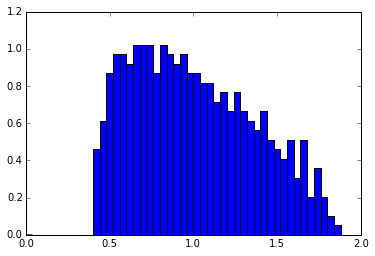

In [63]:
# make a matrix of random returns with the same shape we had before
s = raw_returns.shape
synth_r = np.random.randn(3709, 490)
# compute correlations the old fashioned way
synth_c = compute_timeseries_corr(synth_r)
synth_e = np.linalg.eigvals(synth_c)
plt.hist(synth_e, 50, range=(0.0, rmax), normed=True)
print_eigenvalue_stats(synth_e)
print_corr_stats(synth_c)

This looks very familiar, right?

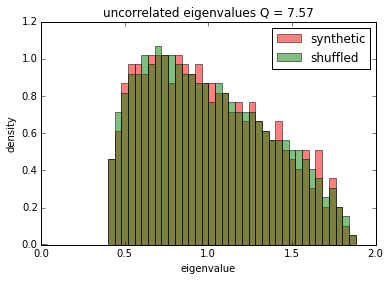

In [64]:
plt.hist(synth_e, 50, range=(0.0, rmax), normed=True, alpha=0.5, color='r', label="synthetic")
plt.hist(shuff_e, 50, range=(0.0, rmax), normed=True, alpha=0.5, color='g', label="shuffled")
plt.xlabel('eigenvalue'), plt.ylabel('density'), plt.title('uncorrelated eigenvalues Q = %.2f' % q), plt.legend()
None

Even with all the strange features of the equity returns, this matches the (Gaussian) random result *almost perfectly*. This is because there is a kind of central limit theorem ("universal law") for these sorts of correlation matrices, called the **Marčenko-Pastur** law.

The most famous result from the theory of random matrices is the so-called **Wigner semicircle law**. This says that if I take an $N\times N$ matrix with elements taken from any reasonable distribution. Then the density of eigenvalues is a semicircle (in the $N\to\infty$ limit). The key point is that there is a minimum and a maximum limit that the eigenvalues cannot exceed.

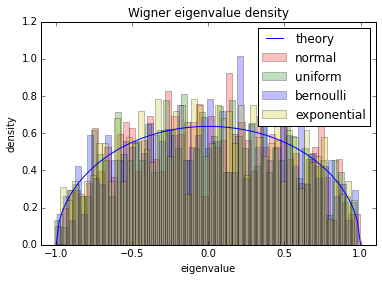

In [65]:
size = 750
def wigner_eigs(color, matrix, name):
    # matrix must be normalized so everything has the same scale
    w = (matrix - np.mean(matrix.flatten())) / (np.sqrt(matrix.shape[0]) * np.std(matrix.flatten()))
    e = np.linalg.eigvals(w)
    plt.hist(e, 50, normed=True, alpha=0.25, color=color, label=name)
wigner_eigs('r', np.random.randn(size, size), 'normal')
wigner_eigs('g', np.random.rand(size, size), 'uniform')
wigner_eigs('b', np.random.random_integers(0, 1, (size, size)), 'bernoulli')
wigner_eigs('y', np.random.exponential(1.0, (size, size)), 'exponential')
plt.title('Wigner eigenvalue density'), plt.xlabel('eigenvalue'), plt.ylabel('density')
plt.xlim( (-1.1, 1.1) )
xs = np.linspace(-1.0, 1.0, 100)
ys = (2.0 / np.pi) * np.sqrt(1.0 - xs * xs)
plt.plot(xs, ys, label='theory')
plt.legend()
None

####Marčenko-Pastur law
Maximum and minimum eigenvalues are between $\lambda_-<\lambda<\lambda_+$ where
$$\lambda_\pm=\sigma^2\biggl(1\pm\sqrt{\frac{1}{Q}}\biggr)^2.$$
Recall that $Q=(\text{# samples})/(\text{# variables})$. This is true as $(\text{# samples})\to\infty$ and $(\text{# variables})\to\infty$ holding $Q$ constant, but in practice gives good results for a moderate number of samples. Between these values the density of eigenvalues is:
$$\rho(\lambda)=\frac{Q}{2\pi\sigma^2}\frac{\sqrt{(\lambda_+-\lambda)(\lambda-\lambda_-)}}{\lambda}.$$
Note that $\sigma$ here is just a scaling (reducing $\sigma$ increases the height and decreases the width). What does this look like?

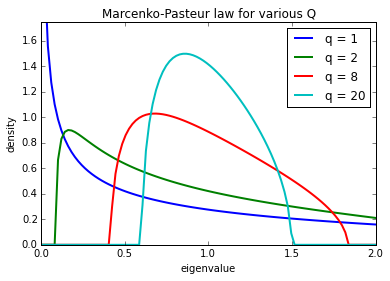

In [146]:
def marcenko_limits(q, sigma):
    """compute upper and lower marcenko limits"""
    ss = sigma * sigma
    delta = 2.0 * ss * np.sqrt(1.0 / q)
    c = ss * (1.0 + 1.0 / q)
    lmax = c + delta
    lmin = c - delta
    return lmin, lmax
def marcenko(xs, q, sigma):
    """vectorized marcenko-pasteur law"""
    lmin, lmax = marcenko_limits(q, sigma)
    fac = q / (2.0 * np.pi * sigma * sigma)
    # nan_to_num is necessary to handle the case lambda = 0, fails to handle this case correctly for q <= 1.0
    return fac * np.sqrt(np.maximum((lmax - xs) * (xs - lmin), 0.0)) * np.nan_to_num(np.reciprocal(xs))
xs = np.linspace(0.001, 2.0, 100)
for qq in [1.0, 2.0, 8.0, 20.0]:
    plt.plot(xs, marcenko(xs, qq, 1.0), label=('q = %.2g' % qq), linewidth=2.0)
plt.legend(), plt.ylim(0.0, 1.75), plt.xlabel('eigenvalue'), plt.ylabel('density'), plt.title('Marcenko-Pasteur law for various Q')
None

The $Q=1$ case is the square of the Wigner semicircle density. The density works for $Q<1$ as well, but a delta function appears at zero: a fraction $1-Q$ of the eigenvalues will always be exactly zero.

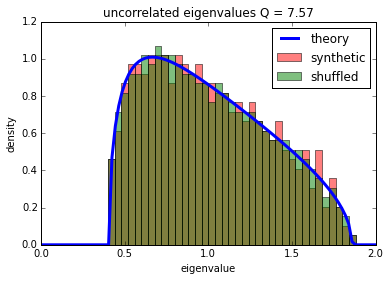

In [69]:
s = raw_returns.shape
q = float(s[0])/ s[1]
plt.hist(synth_e, 50, range=(0.0, rmax), normed=True, alpha=0.5, color='r', label="synthetic")
plt.hist(shuff_e, 50, range=(0.0, rmax), normed=True, alpha=0.5, color='g', label="shuffled")
xs = np.linspace(0.0, 2.0, 100)
plt.plot(xs, marcenko(xs, q, 1.0), label='theory', linewidth=3.0)
plt.xlabel('eigenvalue'), plt.ylabel('density'), plt.title('uncorrelated eigenvalues Q = %.2f' % q), plt.legend()
None

A perfect fit. Now for the real eigenvalues:

Q = 7.6
440 490


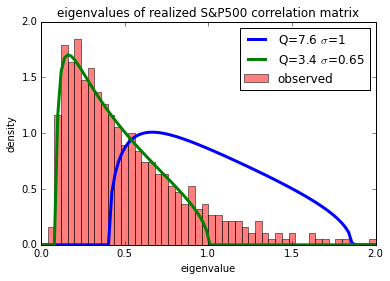

In [144]:
plt.hist(raw_e, 50, range=(0.0, rmax), normed=True, color='r', alpha=0.5, label='observed')
plt.xlabel('eigenvalue'), plt.ylabel('density'), plt.title('eigenvalues of realized S&P500 correlation matrix')
print "Q = %.2g" % q
xs = np.linspace(0.0, 2.0, 100)
plt.plot(xs, marcenko(xs, q, 1.0), label=('Q=%.2g $\sigma$=%.2g' % (q, 1.0)), linewidth=3.0)
eff_q = 0.45 * q
eff_sigma = 0.65
# total density is less than one because we exclude some eigenvalues from MP density
lmin, lmax = marcenko_limits(eff_q, eff_sigma)
scale_factor = float(len(raw_e[np.logical_and(np.less(raw_e, lmax), np.greater(raw_e, lmin))])) / len(raw_e)
plt.plot(xs, scale_factor * marcenko(xs, eff_q, eff_sigma), label=('Q=%.2g $\sigma$=%.2g' % (eff_q, eff_sigma)), linewidth=3.0)
plt.legend()

Using the real values of $\sigma$ and $Q$ doesn't work. The fit changes a lot (note that this is fit by hand, not by any fancy optimization method, sorry). Some of the variance goes into the "real" factors, like the market factor. This is not the only effect. The value of $Q$ is also reduced. (I'm not totally sure what the theory for this is?)

##Optimization and performance of cleaned covariances

Simulation, cross-validation